In [1]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
import sys
import os
from pathlib import Path

# Add parent directory temporarily to sys.path
sys.path.insert(0, str(Path(os.getcwd()).resolve().parent))

In [3]:
from __future__ import annotations
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from lib.State import State

from tqdm.notebook import tqdm

from lib.utils.utils import *

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:

Nx=64
Ny=64

Lx= 10
Ly= 10
T_end = 1
dt = 0.005

myubatch_size = 32768
myu=4
path = f"main-gpu-N-{Nx}-L-{Lx}-Myu-{myu}"
mtlibpath_prefix = path + "_mtl"
model_filepath = f"./models/{path}.pt"


input_to_defect_ratio_sqrt = Nx // myu
N_ITERATIONS = int(T_end / dt)
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=input_to_defect_ratio_sqrt*input_to_defect_ratio_sqrt, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=50, 
    _mean=5.4, 
    std_deviation_run_computation=1,
    input_myu=None
)

100%|██████████| 200/200 [00:00<00:00, 1407.90it/s]

Unique Myus count	 64
Max value of myu:	 98.85197228271444
Min value of myu:	 31.88124086517815
Unique values: [31.88124086517815, 37.359270372192285, 38.2547862344231, 40.403393621893414, 43.05756207168323, 43.24760846995792, 43.753363670372714, 45.05815969328097, 45.987733413536446, 47.076814165092564, 47.58720219369401, 48.67068120615301, 49.24367785201386, 49.28524332778978, 49.33108518051292, 50.32473718921847, 51.443946669041416, 51.80089933009744, 52.02602883875635, 53.53632954870041, 54.6829986222362, 55.14987205756386, 55.43562266557849, 56.20676905089182, 57.06839060892531, 57.90650138957514, 58.685425924785875, 58.796727812331405, 59.781833841923536, 60.392704947691506, 60.62820430629501, 60.752503108835015, 60.922866128937116, 61.43770738474606, 61.48702528832784, 62.546313339358136, 63.17850079341826, 64.51404848902129, 64.88013229482216, 65.00817838529062, 66.26218339532609, 66.52395340558455, 68.17196198382413, 72.46314655157941, 73.32744083352007, 74.15451752168602, 74.

GETTING HANDS DIRTY WITH THE NEURAL NETWORKS

In [5]:
x = np.linspace(-2, 2, Nx).flatten()[:, None]
y = np.linspace(-2, 2, Ny).flatten()[:, None]
t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]

Exact = A_original.squeeze(0)

X, T, Y = np.meshgrid(x, t, y)

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [6]:
from itertools import chain
from lib.nn.nets import LP_XFCN
from lib.CGL import MYULOSS, free_memory

class ALLINPUTNET(LP_XFCN):
    def predict(self, x):
        self.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self.forward(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j    

    def msef(self, y, y_pred):
        return torch.mean((y_pred - y)**2,dim = 0)       

    def zero_grad(self, set_to_none: bool = False) -> None:
        self.encoder._Wtmx.zero_grad()
        self.shuffler._Wtmx.zero_grad()
        self.decoder._Wtmx.zero_grad()
        return super().zero_grad(set_to_none)

    def y_proc(y):
        MS = y[:,1] * y[:,0]
        IR = y[:,1] ** 2 +  y[:,0] ** 2
        return torch.vstack((MS,IR)).T
        
    def fastmsebatchtrain(self, state, epochs = 100, batch_size = 64, verbose = 2, is_simulation = False, device = "cpu"):

        L = []
        for s in state.generate_batches(nbatches = epochs, batch_size = batch_size, verbose = verbose):
            self.optimizer.zero_grad()
            x = s.get_2d_tensor_xyt_lp(device = device).T
            y = s.get_2d_tensor_state_lp(device = device).T
            y_pred = self.forward(x)
            loss = self.msef(
                y_pred if is_simulation else ALLINPUTNET.y_proc(y_pred)
                ,y) 
            L.append(loss.cpu().detach().numpy())
            torch.mean(loss).backward()
            self.optimizer.step()

        return np.array(L)    

In [7]:

class PINN(ALLINPUTNET):
    def __init__(self,*args,**kwargs):
        super(PINN, self).__init__(*args,**kwargs)
        self.myureset()
        self.myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=0.01 ) 

    
    def myureset(self):
        myu = torch.randn(mem_rate, Nx//input_to_defect_ratio_sqrt, Ny//input_to_defect_ratio_sqrt, dtype=torch.float64).to(device)
        myu = nn.Parameter(myu)
        self.myuparam = myu
        
    @property
    def myu(self):
        myu = F.interpolate(self.myuparam.unsqueeze(0), scale_factor=input_to_defect_ratio_sqrt, mode='nearest').squeeze()
        return myu
    
    def loaddata_precalculate(self,state):
        myuloss = MYULOSS.MYUCACHE(self, state)
        myuloss.calculate_f_withoutmyu()
        self.myuloss = myuloss
    
    def fmsef(self, myu):
        return self.myuloss.fmse(myu)
    
    def fmse(self):
        return self.fmsef(self.myu)
    
    def myutrain(self, epochs=100, lr = 0.01):
        
        myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=lr ) 
        myuoptimizer.zero_grad()

        for _ in tqdm(range(epochs)):
            self.fmse().backward(retain_graph=True)
            myuoptimizer.step()
            myuoptimizer.zero_grad()
        
        FMSE = self.myuloss.FMSE
        self.myuloss.clear()
        return FMSE


    def fastmyumsebatchtrain(self, state, epochs = 100, batch_size = 64, verbose = 2, is_simulation = False):
        L = []
        for s in state.generate_batches(nbatches = epochs, batch_size = batch_size, verbose = verbose):
            s.myu = self.myu.flatten()[s.shuffled_indices][s.slice]
            self.optimizer.zero_grad()
            self.myuoptimizer.zero_grad()
            y = s.get_2d_tensor_state().T
            f, y_pred = MYULOSS.net_f(self,s)
            MS, RI = self.msef(
                    y_pred if is_simulation else ALLINPUTNET.y_proc(y_pred)
                ,y)
            FMSE = torch.mean(torch.abs(f) ** 2) / torch.mean(y_pred**2)
            L.append(
                (MS.cpu().detach().numpy(),
                RI.cpu().detach().numpy(),
                FMSE.cpu().detach().numpy())
                )
            (FMSE + MS + RI).backward(retain_graph=True)
            self.optimizer.step()
            self.myuoptimizer.step()
            free_memory(FMSE, MS, RI, f, y_pred)

        return np.array(L)

    def fastmyuonlymsebatchtrain(self, state, epochs = 100, batch_size = 64, verbose = 2, is_simulation = False):
        L = []
        for s in state.generate_batches(nbatches = epochs, batch_size = batch_size, verbose = verbose):
            self.myuoptimizer.zero_grad()
            f, y_pred = MYULOSS.net_f(self,s)
            y = s.get_2d_tensor_state().T
            FMSE = torch.mean(torch.abs(f) ** 2)
            FMSE.backward(retain_graph=True)
            MS, RI = self.msef(
                 y_pred if is_simulation else ALLINPUTNET.y_proc(y_pred)
                ,y)
            L.append(
                (MS.cpu().detach().numpy(),
                RI.cpu().detach().numpy(),
                FMSE.cpu().detach().numpy())
                )
            self.myuoptimizer.step()
            free_memory(FMSE, MS, RI, f, y_pred)

        return np.array(L)
    
    def save_model(self, file_path):
        model_state = {
            'state_dict': self.state_dict(),
            # Add any additional states here if needed
        }
        torch.save(model_state, file_path)
        print(f'Model saved to {file_path}')

    def load_model(self, file_path, device='cpu'):
        model_state = torch.load(file_path, map_location=device)
        self.load_state_dict(model_state['state_dict'])
        # Restore any additional states here if needed
        print(f'Model loaded from {file_path}')

## Training the model and get approximate myus

In [8]:
torch.manual_seed(0)
net = PINN([3, 128, 128, 128, 2]).to(device)
net.device = device
state_simulation = State(state = A_original[0], xyt = np.array([X, Y, T]))
MS = np.abs(A_original)**2
RI = np.real(A_original)*np.imag(A_original)
state_experiment = State(state = (MS + RI*1j)[0], xyt = np.array([X, Y, T]))

state = state_simulation
is_simulation = True

In [9]:
net.optimizer.param_groups[0]['lr'] = 1e-2
L = net.fastmsebatchtrain(state = state, epochs = 500, batch_size = 4096, is_simulation = is_simulation, verbose = 1, device = device)


100%|██████████| 500/500 [00:01<00:00, 451.65it/s]


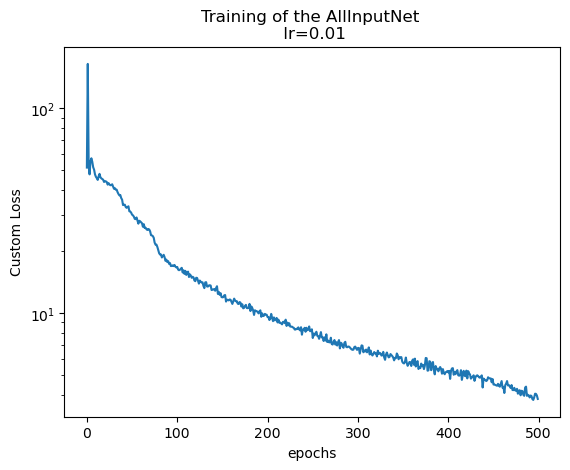

In [10]:
plt.plot(L.sum(axis=1))
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.01')
plt.savefig(f'{mtlibpath_prefix}_allinputnet001.png')

In [11]:
net.optimizer.param_groups[0]['lr'] = 3e-3
L = net.fastmsebatchtrain(state = state, epochs = 100, batch_size = 32768, is_simulation = is_simulation, verbose = 1, device = device)


100%|██████████| 100/100 [00:00<00:00, 294.56it/s]


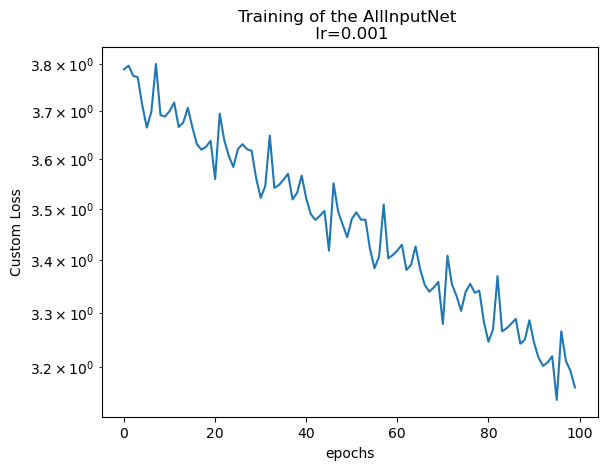

In [12]:
plt.plot(L.sum(axis=1))
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.001')
plt.savefig(f'{mtlibpath_prefix}_allinputnet0001.png')

## calculating myus

In [13]:
torch.cuda.empty_cache()

net = net.to(device)
net.loaddata_precalculate(state)


Processing:   0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [ ]:
i = 0
for lr in [10,1,1e-1,1e-2]:
    L = net.myutrain(lr=lr, epochs=100)    
    l = net.fmse().cpu().detach().numpy()
    L += [l]
    net.myuloss.clear()
 
    plt.plot(range(i,i+len(L)), L, label=f'lr={lr}')
    i+=len(L)-1
    
print(net.myuparam[-1])

plt.yscale('log')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('FMSE')
plt.title('MYU Training')
plt.tight_layout()
plt.savefig(f'{mtlibpath_prefix}_myutraining.png')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: 'PINN' object has no attribute 'myuloss'

## Visualizing and saving plot gifs

In [ ]:
def process_subframe(fig, ax, m, title):
    
    im = ax.imshow(m)
    ax.title.set_position([.5, 1.05])
    im = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    
def process_frame(M, titles):
    figsize = (M.shape[0], M.shape[1])
    fig, axs = plt.subplots(*figsize, figsize=(18, 6))
    
    # Draw
    for i in range(figsize[0]):
        for j in range(figsize[1]):
            ax = axs[i][j]
            process_subframe(fig,axs[i][j], M[i][j],titles[i][j])
            
    # Draw the figure and store the image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close(fig)
    
    return image   

def create_video(M,titles, videotitle, save=True, fps=30):
    
    
    num_cores = multiprocessing.cpu_count()
#    images = Parallel(n_jobs=num_cores)(delayed(process_frame)((m,titles) for m in tqdm(M)))
    images = [process_frame(m,titles) for m in M]
    if save:
        images_to_video(images, videotitle, fps=30)
        print("Video successfully saved at", videotitle)
    
    return None

def create_video(M,titles, videotitle, save=True, fps=30):
    
    
    images = [process_frame(m,titles) for m in M]
    #Parallel(n_jobs=num_cores)(delayed(process_frame)(m, titles) for m in tqdm(M))
    if save:
        # Convert images to 8-bit color for video
        images = [cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in images]
        height, width, _ = images[0].shape
        video = cv2.VideoWriter(videotitle, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
        for img in images:
            video.write(img)
        video.release()
        print("Video successfully saved at", videotitle)
    
    return None

In [ ]:
module_sq = lambda a: np.real(a)**2 + np.imag(a)**2
phase = lambda a: np.arcsin(np.real(a)/np.sqrt(np.real(a)**2+np.imag(a)**2))
real_imag = lambda a: np.real(a)*np.imag(a)
real = lambda a: np.real(a)
imag = lambda a: np.imag(a)

funlist_name = ["module_sq", "phase","real_imag","real","imag"]
funlist = [module_sq, phase, real_imag, real, imag]

myu = myu_original[0]
myupred = net.myu.cpu().detach().numpy()

A_pred = net.predict(state.flatten().get_2d_tensor_xyt().T).reshape(A_original[0].shape)

In [ ]:
ATenzor = np.array([np.stack([
                    np.stack([fun(A) for fun in funlist]),
                    np.stack([fun(Ap) for fun in funlist])
                    ]) for A, Ap in zip(A_original[0], A_pred)])
                    

In [ ]:
MTenzor = np.array([np.array([m,mp]) for m, mp in zip(myu,myupred)])

In [ ]:
AMTenzor = np.concatenate((MTenzor[:, :, np.newaxis, :, :], ATenzor), axis=2)

In [ ]:
create_video(AMTenzor, titles=[['myu'] + funlist_name]*2, videotitle = path+'.mp4')

Video successfully saved at main-test-N-64-L-10-Myu-4.mp4
